# Faster R-CNN in Pytorch with Example

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from skimage import io
from skimage.transform import resize
import matplotlib.pyplot as plt
import random
import matplotlib.patches as patches
from utils import *
from model import *
import os

import torch
import torchvision
from torchvision import ops
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

In [3]:

# --- Device Selection ---
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA GPU")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU)")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using CUDA GPU


### Load Images

**Note:** The annotations should also contain the corresponding image path

In [4]:
# original_img_width = 1920
# original_img_height = 1080

# down_scale_factor = 16

img_width = 1920
img_height = 1080

image_dir = os.path.join("..", "soccernet_data", "tracking", "train", "SNMOT-060")
# annotation_path = "data/annotations.xml"
# image_dir = os.path.join("data", "images")
# name2idx = {'pad': -1, 'camel': 0, 'bird': 1}
# idx2name = {v:k for k, v in name2idx.items()}

#### Create Dataset and Dataloaders

In [5]:
from data_loader import SoccerDatasetSequence, get_dataloader

# od_dataset = ObjectDetectionDataset(annotation_path, image_dir, (img_height, img_width), name2idx)

bs = 3 

# od_dataset = SoccerDatasetSequence((img_height, img_width), image_dir)
# od_dataloader = DataLoader(
#     od_dataset,
#     batch_size=bs,
# )

od_dataloader = get_dataloader(
    sequence_dir=image_dir, 
    img_size=(img_height, img_width), 
    batch_size=bs, 
    shuffle=False # Keep shuffle=False if you want the *first* sequence elements
)


#### Grab a batch for demonstration

In [6]:

img_data_all, gt_bboxes_all, gt_classes_all = next(iter(od_dataloader))
gt_classes_all

tensor([[ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         -1, -1, -1, -1, -1],
        [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         -1, -1, -1, -1, -1],
        [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         -1, -1, -1, -1, -1]])

### Display Images and Bounding Boxes

In [7]:
# get class names
gt_class_1 = gt_classes_all[0].long()
gt_class_1 = ["player" for idx in gt_class_1]

gt_class_2 = gt_classes_all[1].long()
gt_class_2 = ["player" for idx in gt_class_2]

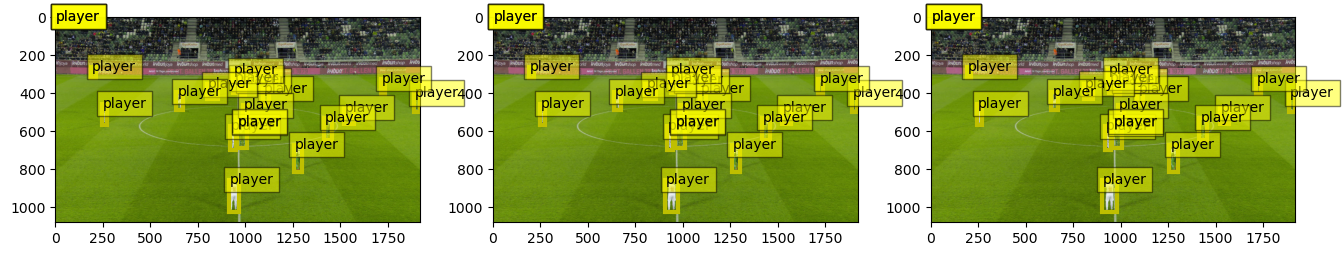

In [8]:
num_images_to_display = bs
nrows, ncols = (1, num_images_to_display)

fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all[:num_images_to_display], fig, axes)

for i in range(num_images_to_display):
    fig, _ = display_bbox(gt_bboxes_all[i], fig, axes[i], classes=gt_class_1)
# fig, _ = display_bbox(gt_bboxes_all[1], fig, axes[1], classes=gt_class_2)

## Convolutional Backbone Network

We will use the first 4 layers of resnet50 as our convolutional backbone

In [9]:
# model = torchvision.models.resnet50(pretrained=True)

In [10]:
# req_layers = list(model.children())[:8]
# backbone = nn.Sequential(*req_layers)
# # unfreeze all the parameters
# for param in backbone.named_parameters():
#     param[1].requires_grad = True

from featureExtractor import InceptionFeatureExtractor
backbone = InceptionFeatureExtractor()
# backbone.eval()


In [11]:
# run the image through the backbone
out = backbone(img_data_all)

In [12]:
out_c, out_h, out_w = out.size(dim=1), out.size(dim=2), out.size(dim=3)

In [13]:
out_c, out_h, out_w

(2048, 32, 58)

#### Check how much the image has been down-scaled

In [14]:



width_scale_factor = img_width // out_w
height_scale_factor = img_height / out_h

# width_scale_factor = round(img_width / out_w)
# height_scale_factor = round(img_height / out_h)

print(img_width, img_height, out_w, out_h)

height_scale_factor, width_scale_factor

1920 1080 58 32


(33.75, 33)

### Visualize feature maps

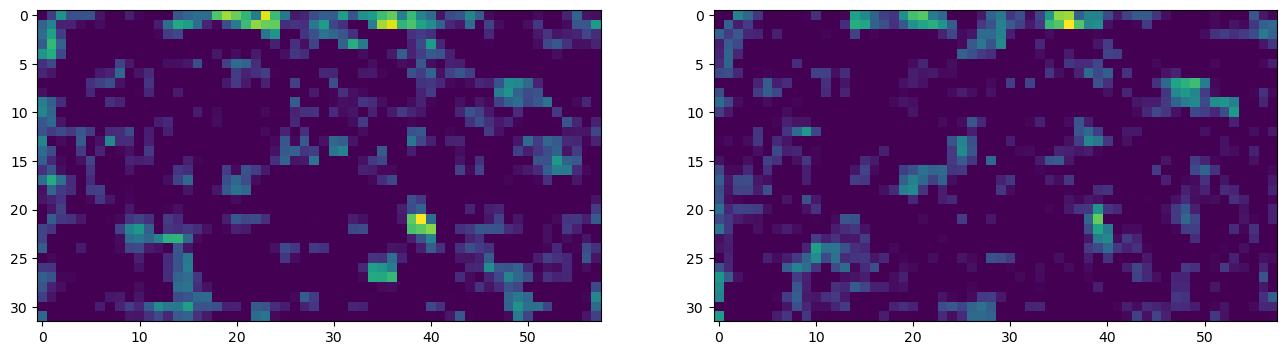

In [15]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

filters_data =[filters[0].detach().numpy() for filters in out[:2]]

fig, axes = display_img(filters_data, fig, axes)

### Generate and Plot Anchor Points

In [16]:
anc_pts_x, anc_pts_y = gen_anc_centers((out_h, out_w), device)

### Display Grid Mapping

In [17]:
# project anchor centers onto the original image
anc_pts_x_proj = anc_pts_x.clone() * width_scale_factor 
anc_pts_y_proj = anc_pts_y.clone() * height_scale_factor

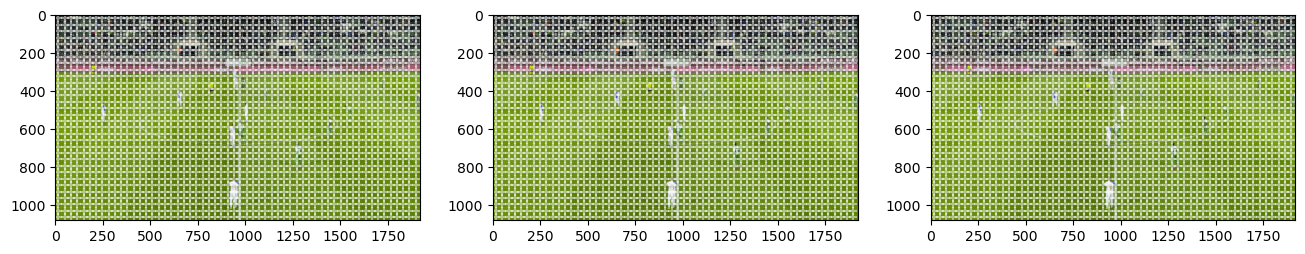

In [18]:
nrows, ncols = (1, num_images_to_display)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all[:num_images_to_display], fig, axes)
for i in range(num_images_to_display):
    fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[i])

### Create Anchor Boxes around Anchor points

In [19]:
anc_scales = [2, 4, 6]
anc_ratios = [0.5, 1, 1.5]
n_anc_boxes = len(anc_scales) * len(anc_ratios) # number of anchor boxes for each anchor point

anc_base = gen_anc_base(anc_pts_x, anc_pts_y, anc_scales, anc_ratios, (out_h, out_w), device)

In [20]:
# since all the images are scaled to the same size
# we can repeat the anchor base for all the images
anc_boxes_all = anc_base.repeat(img_data_all.size(dim=0), 1, 1, 1, 1)

### plot anchor boxes on a single anchor point

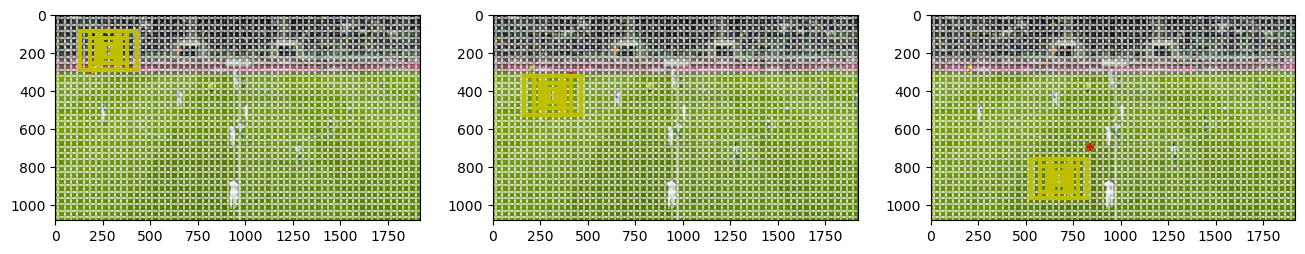

In [21]:
nrows, ncols = (1, num_images_to_display)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all[:num_images_to_display], fig, axes)

# project anchor boxes to the image
anc_boxes_proj = project_bboxes(anc_boxes_all, width_scale_factor, height_scale_factor, mode='a2p')

# plot anchor boxes around selected anchor points
sp = [[5, 8],[12, 9], [25,20]]
# sp_1 = [5, 8]
# sp_2 = [12, 9]
# bboxes_1 = anc_boxes_proj[0][sp_1[0], sp_1[1]]
# bboxes_2 = anc_boxes_proj[1][sp_2[0], sp_2[1]]

for i in range(num_images_to_display):
    sp_i = sp[i]
    bboxes_i = anc_boxes_proj[i][sp_i[0], sp_i[1]]
    fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[i], (anc_pts_x_proj[sp_i[0]], anc_pts_y_proj[sp_i[1]]))
    fig, _ = display_bbox(bboxes_i, fig, axes[i])


# fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0], (anc_pts_x_proj[sp_1[0]], anc_pts_y_proj[sp_1[1]]))
# fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1], (anc_pts_x_proj[sp_2[0]], anc_pts_y_proj[sp_2[1]]))
# fig, _ = display_bbox(bboxes_1, fig, axes[0])
# fig, _ = display_bbox(bboxes_2, fig, axes[1])

### plot all anchor boxes

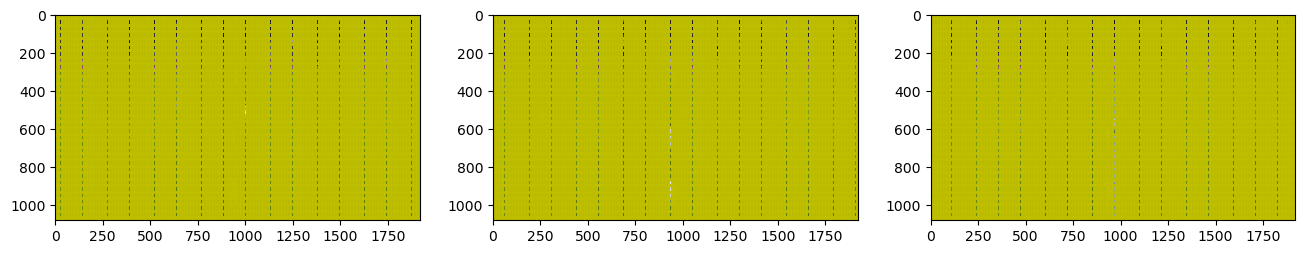

In [22]:
nrows, ncols = (1, num_images_to_display)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

# Move image data to CPU before displaying
img_data_cpu = img_data_all[:num_images_to_display].cpu()
fig, axes = display_img(img_data_cpu, fig, axes)

# Move anchor boxes and points to CPU *before* the loops
anc_pts_x_proj_cpu = anc_pts_x_proj.cpu()
anc_pts_y_proj_cpu = anc_pts_y_proj.cpu()
anc_boxes_proj_cpu = anc_boxes_proj.cpu()

# plot all anchor boxes using CPU tensors and correct indexing
# Iterate Height first (y), then Width (x) to match tensor dims if preferred,
# or keep the loops as is and swap the indexing inside. Let's swap indexing:
for x in range(anc_pts_x_proj_cpu.size(dim=0)):
    for y in range(anc_pts_y_proj_cpu.size(dim=0)):
        # Correct indexing: use [y, x]
        bboxes = anc_boxes_proj_cpu[0][y, x]
        for i in range(num_images_to_display):
            # Pass the CPU tensor bboxes to display_bbox
            display_bbox(bboxes, fig, axes[i], line_width=1)

plt.show()

### Get Positive and Negative Anchors

In [23]:
pos_thresh = 0.7
neg_thresh = 0.3

# project gt bboxes onto the feature map
gt_bboxes_proj = project_bboxes(gt_bboxes_all, width_scale_factor, height_scale_factor, mode='p2a')

In [24]:
positive_anc_ind, negative_anc_ind, GT_conf_scores, \
GT_offsets, GT_class_pos, positive_anc_coords, \
negative_anc_coords, positive_anc_ind_sep = get_req_anchors(anc_boxes_all, gt_bboxes_proj, gt_classes_all, device, pos_thresh, neg_thresh)

#### Visualize positive anchor coordinates

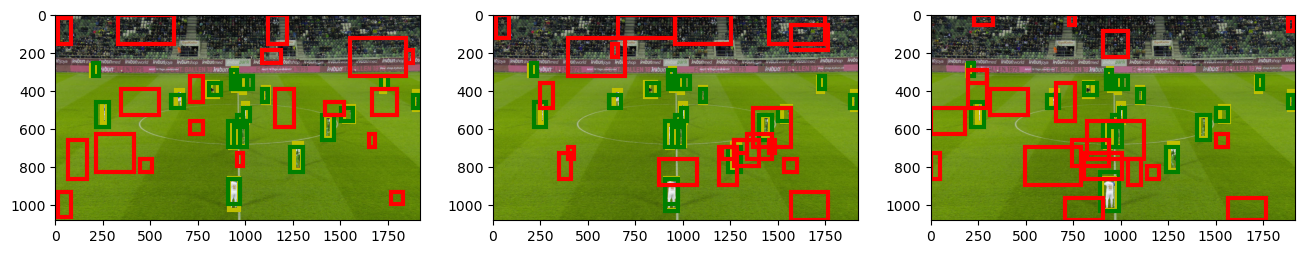

In [25]:
# project anchor coords to the image space
pos_anc_proj = project_bboxes(positive_anc_coords, width_scale_factor, height_scale_factor, mode='a2p')
neg_anc_proj = project_bboxes(negative_anc_coords, width_scale_factor, height_scale_factor, mode='a2p')

# grab +ve and -ve anchors for each image separately
fig, axes = plt.subplots(nrows, num_images_to_display, figsize=(16, 8))
fig, axes = display_img(img_data_all[:num_images_to_display], fig, axes)

anc_idx = [] 
pos_anc = []
neg_anc = []
for i in range(num_images_to_display):
    anc_idx.append(torch.where(positive_anc_ind_sep == i)[0])
    pos_anc.append(pos_anc_proj[anc_idx[i]])
    neg_anc.append(neg_anc_proj[anc_idx[i]])

    #display ground truth bboxes
    fig, _ = display_bbox(gt_bboxes_all[i], fig, axes[i])
    #display positive anchor boxes
    fig, _ = display_bbox(pos_anc[i], fig, axes[i], color='g')
    #display negative anchor boxes
    fig, _ = display_bbox(neg_anc[i], fig, axes[i], color='r')




# anc_idx_1 = torch.where(positive_anc_ind_sep == 0)[0]
# anc_idx_2 = torch.where(positive_anc_ind_sep == 1)[0]

# pos_anc_1 = pos_anc_proj[anc_idx_1]
# pos_anc_2 = pos_anc_proj[anc_idx_2]

# neg_anc_1 = neg_anc_proj[anc_idx_1]
# neg_anc_2 = neg_anc_proj[anc_idx_2]

### Building the model

In [28]:
img_size = (img_height, img_width)
out_size = (out_h, out_w)
out_channels = out_c
roi_size = (2, 2)
n_classes = 2 # number of classes (excluding background)
# (img_size, out_channels, n_classes, roi_size)
detector = TwoStageDetector(img_size, out_channels, n_classes, roi_size)

/home/bada/anaconda3/envs/practice/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bada/anaconda3/envs/practice/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [29]:
# detector.eval()
# total_loss = detector(img_data_all, gt_bboxes_all, gt_classes_all)
# proposals_final, conf_scores_final, classes_final = detector.inference(img_data_all)

# Assuming 'device' is defined earlier (e.g., device = torch.device("cuda") or "mps" or "cpu")
# Assuming img_data_all, gt_bboxes_all, gt_classes_all are already loaded tensors

# Move the model to the selected device FIRST
detector.to(device)
detector.eval() # Now call eval() after moving the model

# Move data to the selected device
img_data_all_dev = img_data_all.to(device)
gt_bboxes_all_dev = gt_bboxes_all.to(device)
gt_classes_all_dev = gt_classes_all.long().to(device) # Ensure long type and device

with torch.no_grad(): # Use no_grad for evaluation/inference
    # Pass device to the forward call (model is already on device)
    total_loss = detector(img_data_all_dev, gt_bboxes_all_dev, gt_classes_all_dev, device=device)

    # Pass device to the inference call (model is already on device)
    proposals_final, conf_scores_final, classes_final = detector.inference(img_data_all_dev, device=device)

# Move results back to CPU if needed for visualization/further processing
# proposals_final = [p.cpu() for p in proposals_final]
# conf_scores_final = [cs.cpu() for cs in conf_scores_final]
# classes_final = [c.cpu() for c in classes_final] # Assuming classes_final contains tensors

print(f"Total Loss (Evaluation): {total_loss.item()}")
# You can now work with proposals_final, conf_scores_final, classes_final

Total Loss (Evaluation): 63.19883728027344


### Training loop

In [30]:
# def training_loop(model, learning_rate, train_dataloader, n_epochs):
    
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
#     model.train()
#     loss_list = []
    
#     for i in tqdm(range(n_epochs)):
#         total_loss = 0
#         for img_batch, gt_bboxes_batch, gt_classes_batch in train_dataloader:
            
#             # forward pass
#             loss = model(img_batch, gt_bboxes_batch, gt_classes_batch)
            
#             # backpropagation
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
            
#             total_loss += loss.item()
        
#         loss_list.append(total_loss)
        
#     return loss_list

# learning_rate = 1e-3
# n_epochs = 1

# loss_list = training_loop(detector, learning_rate, od_dataloader, n_epochs)

In [31]:
# learning_rate = 1e-3
# n_epochs = 1

# loss_list = training_loop(detector, learning_rate, od_dataloader, n_epochs)

In [49]:
# Add this block at the beginning of your notebook or script
# Add this block at the beginning of your notebook or script if not already present
import torch
from tqdm import tqdm
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast # For mixed precision
import gc
# # --- Device Selection ---
# if torch.cuda.is_available():
#     device = torch.device("cuda")
#     print("Using CUDA GPU")
# elif torch.backends.mps.is_available():
#     device = torch.device("mps")
#     print("Using MPS (Apple Silicon GPU)")
# else:
#     device = torch.device("cpu")
#     print("Using CPU")

# --- Modified Training Loop ---
def training_loop(model, learning_rate, train_dataloader, n_epochs, device):

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scaler = GradScaler(enabled=(device.type == 'cuda')) # Enable scaler only for CUDA

    model.to(device) # Move model to the selected device
    model.train()
    loss_list = []

    for i in range(n_epochs):
        print(f"Epoch {i+1}/{n_epochs}")
        total_loss = 0
        loop = tqdm(train_dataloader, leave=True)
        for img_batch, gt_bboxes_batch, gt_classes_batch in loop:

            # Move data to device
            img_batch = img_batch.to(device)
            gt_bboxes_batch = gt_bboxes_batch.to(device)
            # ***** Ensure gt_classes are LongTensor and moved to device *****
            # Assuming gt_classes_batch is a tensor from the dataloader
            gt_classes_batch = gt_classes_batch.long().to(device)


            optimizer.zero_grad(set_to_none=True) # Use set_to_none=True for potential minor performance gain

            # Use autocast for mixed precision (only effective on CUDA)
            with autocast(enabled=(device.type == 'cuda')):
                # Pass device to model's forward pass
                loss = model(img_batch, gt_bboxes_batch, gt_classes_batch, device=device)

            if torch.isnan(loss):
                print("Warning: NaN loss detected. Skipping batch.")
                # Consider zeroing gradients again if skipping
                optimizer.zero_grad(set_to_none=True)
                continue

            # Scale loss and backpropagate
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            batch_loss = loss.item()
            total_loss += batch_loss

            # Update tqdm progress bar description
            loop.set_description(f"Epoch {i+1}")
            loop.set_postfix(loss=batch_loss)

            del img_batch, gt_bboxes_batch, gt_classes_batch, loss
            torch.cuda.empty_cache()
            gc.collect()

        avg_epoch_loss = total_loss / len(train_dataloader)
        loss_list.append(avg_epoch_loss)
        print(f"Epoch {i+1} Average Loss: {avg_epoch_loss:.4f}")

    return loss_list

# --- Running the training --- (Ensure detector and od_dataloader are defined)
# learning_rate = 1e-3
# n_epochs = 1
# loss_list = training_loop(detector, learning_rate, od_dataloader, n_epochs, device)



# Move results back to CPU if needed for plotting or further processing
# proposals_final = [p.cpu() for p in proposals_final]
# conf_scores_final = [cs.cpu() for cs in conf_scores_final]
# classes_final = [c.cpu() for c in classes_final] # If classes are tensors

In [50]:
import gc
# Clear CUDA cache and collect garbage
if device.type == 'cuda':
    torch.cuda.empty_cache() # Clear CUDA cache
    gc.collect() # Collect garbage
    
# Clear MPS cache if using MPS
if device.type == 'mps':
    import mps
    mps.empty_cache()

bs = 3

od_dataloader = get_dataloader(
    sequence_dir=image_dir, 
    img_size=(img_height, img_width), 
    batch_size=bs, 
    shuffle=False # Keep shuffle=False if you want the *first* sequence elements
)

# --- Running the training ---
learning_rate = 1e-4 # You might need to adjust this, especially with AMP
n_epochs = 5 # Keep it at 1 for now to test speed


# Make sure your dataloader (od_dataloader) is defined before this
# Ensure your model (detector) is defined before this
loss_list = training_loop(detector, learning_rate, od_dataloader, n_epochs, device)

# --- Modify Inference Call ---
# Make sure to move images to the device for inference too
detector.eval()
# Assuming img_data_all is your batch of images for inference
img_data_all = img_data_all.to(device)
with torch.no_grad():
    # Pass device to inference as well if needed by internal functions
    # (We'll modify the model next to handle this)
    proposals_final, conf_scores_final, classes_final = detector.inference(img_data_all, device=device)

Epoch 1/5


Epoch 1: 100%|██████████| 250/250 [13:51<00:00,  3.33s/it, loss=55.6]


Epoch 1 Average Loss: 43.2542
Epoch 2/5


Epoch 2: 100%|██████████| 250/250 [13:35<00:00,  3.26s/it, loss=53.4]


Epoch 2 Average Loss: 42.6282
Epoch 3/5


Epoch 3: 100%|██████████| 250/250 [13:53<00:00,  3.33s/it, loss=53.9]


Epoch 3 Average Loss: 42.2512
Epoch 4/5


Epoch 4: 100%|██████████| 250/250 [13:44<00:00,  3.30s/it, loss=55.5]


Epoch 4 Average Loss: 42.0946
Epoch 5/5


Epoch 5: 100%|██████████| 250/250 [13:38<00:00,  3.27s/it, loss=54.4]


Epoch 5 Average Loss: 42.0203


In [51]:
loss_list

[43.254218757629395,
 42.62824362945557,
 42.2512437286377,
 42.09464749908447,
 42.02029552459717]

#### save model

In [52]:
from datetime import datetime
date_time = datetime.now().strftime("%m_%d_%Y-%H:%M:%S")
torch.save(detector.state_dict(), f"checkpoints/checkpoint_model_{date_time}.pt")

### Inference

In [53]:
detector.eval()
proposals_final, conf_scores_final, classes_final = detector.inference(img_data_all, device, conf_thresh=0.90, nms_thresh=0.05)
proposals_final

[tensor([[ 6.9024e+00,  1.4300e+01,  9.6940e+00,  1.9878e+01],
         [-4.8310e-02,  1.4348e+01,  1.8549e+00,  2.0060e+01],
         [ 1.9661e+00,  1.6436e+01,  2.9124e+00,  1.8334e+01],
         [ 5.0372e+01,  1.3370e+01,  5.6120e+01,  1.9117e+01],
         [ 4.6459e+01,  1.5458e+01,  4.8377e+01,  1.7376e+01],
         [ 6.4514e+00,  1.2452e+01,  8.3618e+00,  1.4363e+01],
         [ 2.1968e+01,  1.2434e+01,  2.2902e+01,  1.4300e+01],
         [ 3.8338e+01,  1.8342e+01,  4.2054e+01,  2.2061e+01]], device='cuda:0'),
 tensor([[ 6.4410e+00,  1.5364e+01,  8.2982e+00,  1.9074e+01],
         [ 1.8924e+01,  1.4359e+01,  2.1785e+01,  2.0074e+01],
         [-4.8365e-02,  1.4348e+01,  1.8549e+00,  2.0060e+01],
         [ 1.3973e+01,  1.6449e+01,  1.4917e+01,  1.8335e+01],
         [ 4.8804e+01,  1.3368e+01,  5.7416e+01,  1.9107e+01]], device='cuda:0'),
 tensor([[-4.8324e-02,  1.4348e+01,  1.8549e+00,  2.0060e+01],
         [ 6.4409e+00,  1.5363e+01,  8.2981e+00,  1.9074e+01],
         [ 1.8893

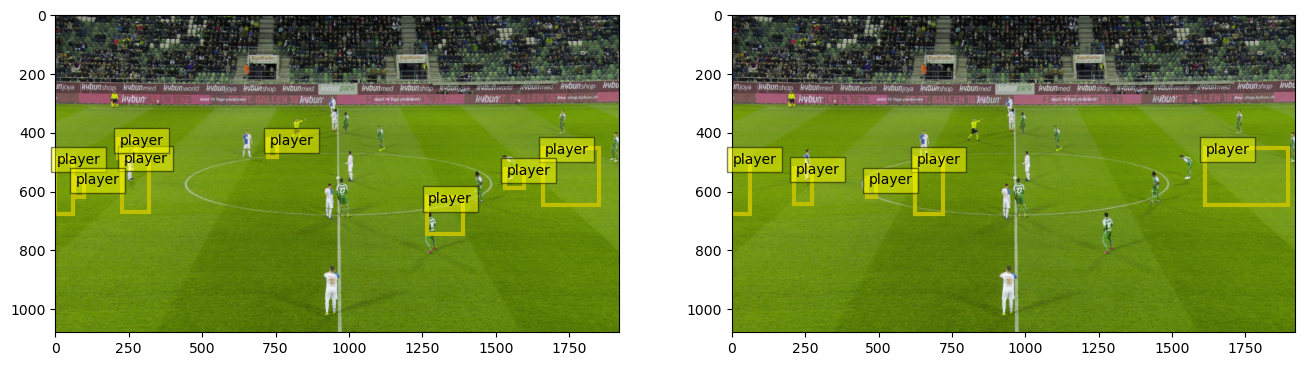

In [54]:
# prop_proj_1 = project_bboxes(proposals_final[0], width_scale_factor, height_scale_factor, mode='a2p').cpu()
# prop_proj_2 = project_bboxes(proposals_final[1], width_scale_factor, height_scale_factor, mode='a2p').cpu()
# classes_pred_1 = ["player" for cls in classes_final[0].tolist()]
# classes_pred_2 = ["player" for cls in classes_final[1].tolist()]

if proposals_final[0].numel() > 0:
    prop_proj_1 = project_bboxes(proposals_final[0], width_scale_factor, height_scale_factor, mode='a2p').cpu()
    classes_pred_1 = ["player" for cls in classes_final[0].tolist()]
else:
    prop_proj_1 = torch.empty(0, 4)
    classes_pred_1 = []

if proposals_final[1].numel() > 0:
    prop_proj_2 = project_bboxes(proposals_final[1], width_scale_factor, height_scale_factor, mode='a2p').cpu()
    classes_pred_2 = ["player" for cls in classes_final[1].tolist()]
else:
    prop_proj_2 = torch.empty(0, 4)
    classes_pred_2 = []



nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))
fig, axes = display_img(img_data_all[:2], fig, axes)
fig, _ = display_bbox(prop_proj_1, fig, axes[0], classes=classes_pred_1)
fig, _ = display_bbox(prop_proj_2, fig, axes[1], classes=classes_pred_2)
plt.show()

In [40]:
# img_data_cpu = img_data_all[:2].cpu()
# prop_proj_1_cpu = prop_proj_1.cpu()
# prop_proj_2_cpu = prop_proj_2.cpu()

# # Handle classes - they might be tensors or lists/arrays
# classes_pred_1_cpu = classes_pred_1.cpu() if isinstance(classes_pred_1, torch.Tensor) else classes_pred_1
# classes_pred_2_cpu = classes_pred_2.cpu() if isinstance(classes_pred_2, torch.Tensor) else classes_pred_2


# nrows, ncols = (1, 2)
# fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

# # Call display functions directly - they modify fig and axes in-place
# # No need to capture return values here
# display_img(img_data_cpu, fig, axes)
# display_bbox(prop_proj_1_cpu, fig, axes[0], classes=classes_pred_1_cpu)
# display_bbox(prop_proj_2_cpu, fig, axes[1], classes=classes_pred_2_cpu)

# plt.show() # Explicitly request to show the plot

In [42]:
# # project proposals to the image space
# # prop_proj_3 = project_bboxes(proposals_final[2], width_scale_factor, height_scale_factor, mode='a2p')


# # prop_proj = [prop_proj_1, prop_proj_2, prop_proj_3]

# # get classes
# classes_pred_1 = ["player" for cls in classes_final[0].tolist()]
# classes_pred_2 = ["player" for cls in classes_final[1].tolist()]
# # classes_pred_1 = [idx2name[cls] for cls in classes_final[0].tolist()]
# # classes_pred_2 = [idx2name[cls] for cls in classes_final[1].tolist()]



if proposals_final[0].numel() > 0:
    prop_proj_1 = project_bboxes(proposals_final[0], width_scale_factor, height_scale_factor, mode='a2p').cpu()
    classes_pred_1 = ["player" for cls in classes_final[0].tolist()]
else:
    prop_proj_1 = torch.empty(0, 4)
    classes_pred_1 = []

if proposals_final[1].numel() > 0:
    prop_proj_2 = project_bboxes(proposals_final[1], width_scale_factor, height_scale_factor, mode='a2p').cpu()
    classes_pred_2 = ["player" for cls in classes_final[1].tolist()]
else:
    prop_proj_2 = torch.empty(0, 4)
    classes_pred_2 = []


In [43]:
# # nrows, ncols = (1, 2)
# # fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

# # fig, axes = display_img(img_data_all[:2], fig, axes)
# # fig, _ = display_bbox(prop_proj_1, fig, axes[0], classes=classes_pred_1)
# # fig, _ = display_bbox(prop_proj_2, fig, axes[1], classes=classes_pred_2)

# nrows, ncols = (1, 2)
# fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8)) # Create fig, axes

# # Reassign fig, axes based on return value (modifies originals in-place)
# fig, axes = display_img(img_data_all[:2], fig, axes)
# # Reassign fig based on return value (modifies originals in-place)
# fig, _ = display_bbox(prop_proj_1, fig, axes[0], classes=classes_pred_1)
# # Reassign fig based on return value (modifies originals in-place)
# fig, _ = display_bbox(prop_proj_2, fig, axes[1], classes=classes_pred_2)

In [44]:
%matplotlib inline
# %matplotlib notebook

In [45]:
# nrows, ncols = (1, 2)
# fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

# fig, axes = display_img(img_data_all[:2], fig, axes)
# fig, _ = display_bbox(prop_proj_1, fig, axes[0], classes=classes_pred_1)
# fig, _ = display_bbox(prop_proj_2, fig, axes[1], classes=classes_pred_2)
# plt.show()

In [46]:
# import matplotlib
# matplotlib.use('Agg') # Explicitly set backend (might not be necessary, but worth trying)
# import matplotlib.pyplot as plt

# import torch # Import torch if not already done

# # Assuming prop_proj_1, prop_proj_2, classes_pred_1, classes_pred_2, img_data_all exist

# # --------------------------------------------------
# # 1. Prepare CPU Data
# # --------------------------------------------------
# img_data_cpu = img_data_all[:2].cpu()

# # Ensure proposals are tensors and on CPU
# prop_proj_1_cpu = torch.as_tensor(prop_proj_1).cpu()
# prop_proj_2_cpu = torch.as_tensor(prop_proj_2).cpu()

# # Handle classes - they might be tensors or lists/arrays. Ensure CPU if tensor.
# def to_cpu_if_tensor(data):
#     return data.cpu() if isinstance(data, torch.Tensor) else data

# classes_pred_1_cpu = to_cpu_if_tensor(classes_pred_1)
# classes_pred_2_cpu = to_cpu_if_tensor(classes_pred_2)

# # --------------------------------------------------
# # 2. Create Figure and Axes
# # --------------------------------------------------
# nrows, ncols = (1, 2)
# fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

# # --------------------------------------------------
# # 3. Draw onto Axes (Modify axes in-place)
# # --------------------------------------------------
# # Pass the whole axes array to display_img if it handles multiple axes
# # Or iterate if it expects one axis per image in the batch
# if isinstance(axes, matplotlib.axes.Axes): # If only one subplot (ncols=1)
#      display_img(img_data_cpu, fig, [axes]) # Wrap in list if display_img expects array
# else: # If multiple subplots (ncols > 1)
#      display_img(img_data_cpu, fig, axes) # Pass the array directly

# # Pass the specific axis object to display_bbox
# display_bbox(prop_proj_1_cpu, fig, axes[0], classes=classes_pred_1_cpu)
# display_bbox(prop_proj_2_cpu, fig, axes[1], classes=classes_pred_2_cpu)

# # --------------------------------------------------
# # 4. Display Figure
# # --------------------------------------------------
#  # Explicitly request to show the plot

# # Or, if in Jupyter/IPython, just letting the cell end should display 'fig'
# # fig
# fig